In [ ]:
!pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 113 kB 5.0 MB/s 
     |████████████████████████████████| 48.3 MB 95 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
!pip install opencv-contrib-python==4.5.5.62

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 66.6 MB 114 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
%matplotlib inline

In [ ]:
import cv2
import numpy as np
import albumentations as A

from matplotlib import pyplot as plt

In [ ]:
def get_classes_dict(classes_file: str) -> dict:
  classes = {}

  with open(classes_file) as classes_file:
    data = classes_file.read()
    classes = {index: value for index, value in enumerate(
      data.split()
    )}
  
  return classes

In [ ]:
classes = get_classes_dict('classes.txt')
classes

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'H',
 7: 'L',
 8: 'M',
 9: 'N',
 10: 'O',
 11: 'P',
 12: 'R',
 13: 'S',
 14: 'T',
 15: 'U',
 16: 'V',
 17: 'W',
 18: 'Y',
 19: 'I'}

In [ ]:
def show_yolo_img(img: np.ndarray, boxes: list):
  dh, dw, _ = img.shape
  x, y, w, h = tuple(boxes)

  l = int((x - w / 2) * dw)
  r = int((x + w / 2) * dw)
  t = int((y - h / 2) * dh)
  b = int((y + h / 2) * dh)

  if l < 0:
      l = 0
  if r > dw - 1:
      r = dw - 1
  if t < 0:
      t = 0
  if b > dh - 1:
      b = dh - 1

  img_result = cv2.rectangle(
    img,
    (l, t), (r, b),
    color=(5, 63, 1), thickness=20
  )

  plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
bbox_params = A.BboxParams(
  format="yolo",  
  min_visibility=0.4, 
  label_fields=[]
)

augment_image = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.8),
    A.GaussNoise(p=0.5),
    A.ChannelShuffle(p=0.2),
    A.RandomSnow(p=0.2),
    A.RandomToneCurve(),
    A.LongestMaxSize()
], bbox_params=bbox_params)

In [ ]:
class YoloImg:
  def __init__(self, img_path: str, boxes_file_path: str) -> None:
      image = cv2.imread(img_path)
      self.image = cv2.imread(img_path)

      label_boxes_file = open(boxes_file_path)
      label_boxes_values = label_boxes_file.read().split()
      label_boxes_file.close()

      self.boxes = self._get_boxes(label_boxes_values)
      self.categories = self._get_categories(label_boxes_values)

  def _get_boxes(self, label_boxes_values: list) -> list:
      return [[float(i) for i in label_boxes_values[1:]]]
  
  def _get_categories(self, label_boxes_values: list) -> list:
      return [int(i) for i in label_boxes_values[:1]]

class YoloImgSaver:
  def __init__(self, 
                img: np.ndarray, 
                boxes: list, 
                label_index: int,
                id: str
                ) -> None:
      self.img = img
      self.boxes = boxes
      self.label_index = label_index
      self.id = id

  @property
  def label(self) -> str:
    label = classes[self.label_index]
    return label

  @property
  def name(self) -> str:
    return f'{self.label}_{self.id}'

  def save_img(self, extension):
    label = classes[self.label_index]
    cv2.imwrite(f'{self.name}.{extension}', self.img)

  def save_txt_tag(self):
    txt_string = ''
    count = 0
    for boxes in self.boxes:
      txt_string += f'{self.label_index} ' + ' '.join(str(x) for x in boxes)
      if count > 0:
        txt_string += '\n'
      count += 1

    with open(f'{self.name}.txt', 'w') as txt:
      txt.write(txt_string)

## Probar funcionamineto del data augmentation

In [ ]:
img_p = cv2.imread('/content/DATASET_LISAM_2/A_A_IMG_20220622_125608851.jpg')
img_p.shape

(1600, 1200, 3)

In [ ]:
boxes_p = []
with open('/content/DATASET_LISAM_2/A_A_IMG_20220622_125608851.txt') as b_txt:
  tag_yolo = b_txt.read().split()
  boxes_p = [float(x) for x in tag_yolo[1:]]

boxes_p

[0.450833, 0.384375, 0.783333, 0.43875]

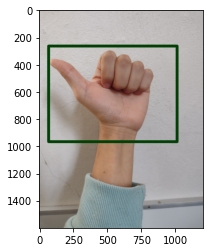

In [ ]:
show_yolo_img(img_p, boxes_p)

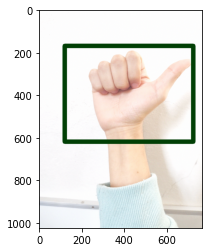

In [ ]:
augment_data = augment_image(image=img_p, bboxes=[boxes_p])
show_yolo_img(augment_data['image'], augment_data['bboxes'][0])